In [63]:
f_leftandright = open('leftandright', 'rb')
left_lst = []
right_lst = []
pan_lst = []
tilt_lst = []

for i in range(5120):
  left = f_leftandright.read(4)
  right = f_leftandright.read(4)
  pan = f_leftandright.read(4)
  tilt = f_leftandright.read(4)
  left_lst.append(int.from_bytes(left, byteorder = 'little' ,signed = True))
  right_lst.append(int.from_bytes(right, byteorder = 'little' ,signed = True))
  pan_lst.append(int.from_bytes(pan, byteorder = 'little' ,signed = True))
  tilt_lst.append(int.from_bytes(tilt, byteorder = 'little' ,signed = True))

f_offset = open('offset', 'rb')
panoff_lst = []
tiltoff_lst = []
rotateoff_lst = []
tranoff_lst = []

for i in range(5120):
  panoff = f_offset.read(4)
  tiltoff = f_offset.read(4)
  rotateoff = f_offset.read(4)
  tranoff = f_offset.read(4)
  panoff_lst.append(int.from_bytes(panoff, byteorder = 'little' ,signed = True))
  tiltoff_lst.append(int.from_bytes(tiltoff, byteorder = 'little' ,signed = True))
  rotateoff_lst.append(int.from_bytes(rotateoff, byteorder = 'little' ,signed = True))
  tranoff_lst.append(int.from_bytes(tranoff, byteorder = 'little' ,signed = True))

rotatecom = []
translatecom = []
for i in range(5120):
  rotatecom.append((right_lst[i] - left_lst[i])/2)
  translatecom.append((right_lst[i] + left_lst[i])/2)


In [64]:
import numpy as np

import tensorflow as tf

In [65]:
size = 5120
datanum = 10
purpose_offset = tranoff_lst
purpose_value = translatecom

In [66]:
input_lst = []
for i in range(size - datanum + 1):
  box = []
  for j in range(i, i+datanum, 1):
    box.append(purpose_offset[j])
  input_lst.append(box)

label_lst = []
for i in range(datanum - 1, size, 1):
  box = []
  box.append(purpose_value[i])
  label_lst.append(box)

In [67]:
rotateoff_numpy = np.array(input_lst)
rotatecom_numpy = np.array(label_lst)

In [68]:
mean_vals = np.mean(rotateoff_numpy, axis=0)
std_val = np.std(rotateoff_numpy)

mean_vals_com = np.mean(rotatecom_numpy, axis=0)
std_val_com = np.std(rotatecom_numpy)

In [69]:
rotateoff_numpy_centered = (rotateoff_numpy - mean_vals)/std_val
rotatecom_numpy_centered = (rotatecom_numpy - mean_vals_com)/std_val_com

# rotateoff_numpy_centered = (rotateoff_numpy - np.max(rotateoff_numpy))/(np.max(rotateoff_numpy) - np.min(rotateoff_numpy))
# rotatecom_numpy_centered = (rotatecom_numpy - np.max(rotatecom_numpy))/(np.max(rotatecom_numpy) - np.min(rotatecom_numpy))

In [70]:
train_x = np.ones((4000, datanum))
train_y = np.ones((4000, 1))
test_x = np.ones((1120 - datanum + 1, datanum))
test_y = np.ones((1120 - datanum + 1, 1))

for i in range(4000):
  train_x[i] = rotateoff_numpy_centered[i]
  train_y[i] = rotatecom_numpy_centered[i]

for i in range(4000, 5120 - datanum + 1, 1):
  test_x[i - 4000] = rotateoff_numpy_centered[i]
  test_y[i - 4000] = rotatecom_numpy_centered[i]

In [71]:
print(test_x)

[[-2.89423516e-02  3.69857870e-04 -4.37991529e-01 ... -1.33551199e+00
  -1.41559012e+00 -1.49575000e+00]
 [ 9.05178470e-04 -4.37393917e-01 -1.00509460e+00 ... -1.41510541e+00
  -1.49518353e+00 -1.52559753e+00]
 [-4.36858596e-01 -1.00449699e+00 -6.36975063e-01 ... -1.49469882e+00
  -1.52503106e+00 -1.51564835e+00]
 ...
 [ 1.24455227e+00  2.02682113e-02 -2.88753879e-01 ...  1.17168053e+00
   1.43982359e+00  1.46910466e+00]
 [ 2.08035319e-02 -2.88156266e-01  1.46230122e+00 ...  1.44030830e+00
   1.46967112e+00  1.29996865e+00]
 [-2.87620946e-01  1.46289883e+00  1.70108146e+00 ...  1.47015583e+00
   1.30053512e+00  1.25022277e+00]]


In [72]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=50,    
        input_dim = train_x.shape[1],
        kernel_initializer='glorot_normal',
        bias_initializer='zeros',
        activation='tanh'))
model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(
    tf.keras.layers.Dense(
        units=100,    
        input_dim=100,
        kernel_initializer='glorot_normal',
        bias_initializer='zeros',
        activation='tanh'))
model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(
    tf.keras.layers.Dense(
        units=train_y.shape[1],    
        input_dim=100,
        kernel_initializer='glorot_normal',
        bias_initializer='zeros',
        activation=None))

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                550       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [74]:
sgd_optimizer = tf.keras.optimizers.SGD(
    lr=0.000001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer,
              loss='mse')

In [75]:
history = model.fit(train_x, train_y,
                    batch_size=1, epochs=50,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/50
3600/3600 [==============================] - 4s 1ms/step - loss: 1.2005 - val_loss: 1.3037
Epoch 2/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.5977 - val_loss: 0.9782
Epoch 3/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4880 - val_loss: 0.8458
Epoch 4/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4629 - val_loss: 0.7809
Epoch 5/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4864 - val_loss: 0.7467
Epoch 6/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4344 - val_loss: 0.7219
Epoch 7/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3848 - val_loss: 0.7055
Epoch 8/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3673 - val_loss: 0.6906
Epoch 9/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4129 - val_loss: 0.6787
Epoch 10/50
3600/3600 [==============================] - 4s 1ms/step - loss: 0.405

1111/1111 [==============================] - 1s 796us/step - loss: 0.3031
[[ 1.3724564]
 [ 1.3703698]
 [ 1.4620043]
 ...
 [-1.1990145]
 [-1.0892879]
 [-1.1130947]]


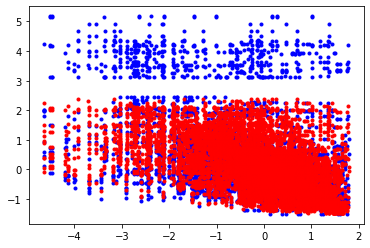

[0.73133072]


In [76]:
import matplotlib.pyplot as plt

loss_and_metrics = model.evaluate(test_x, test_y, batch_size=1)
xhat = test_x
yhat = model.predict(xhat)
print(yhat)


SSE_lst = [] 
SST_lst = []

means = test_y.sum()/test_y.shape[0]

for i in range(xhat.shape[0]):
  SSE_lst.append((test_y[i] - yhat[i])**2)
  SST_lst.append((test_y[i] - means)**2)

R_square = 1 - (sum(SSE_lst) / sum(SST_lst))


plt.plot(test_x, test_y, '.', color = 'b') 
plt.plot(xhat, yhat, '.', color = 'r') 

plt.show()

print(R_square)


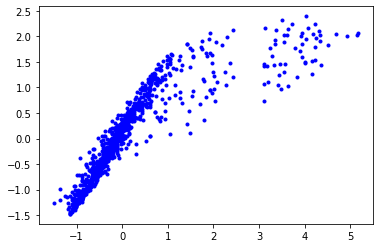

In [77]:
plt.plot(test_y, yhat, '.', color = 'b') 


plt.show()
